## Draw point in image

In [1]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display
from vis_utils import draw_points, draw_landmarks

In [4]:
import pickle

def load_landmarks(lm_path):
    """Load the landmarks from different file format to a numpy array.

    Args:
        lm_path (str|Path): landmark file path

    Raises:
        ValueError: Unvalid landmark file format

    Returns:
        np.ndarray: (N, M) facial landmarks
    """
    if lm_path.endswith(".pkl"):
        with open(lm_path, 'rb') as f:
            landmark = pickle.load(f)
    elif lm_path.endswith(".txt"):
        landmark = np.loadtxt(lm_path)
    elif lm_path.endswith(".npy"):
        landmark = np.load(lm_path)
    else:
        raise ValueError("Unknown file type")
    return landmark

[[ 73.04118529 134.55776818]
 [130.79305837 136.95011541]
 [ 85.0029326  100.72207773]
 [ 75.7763394   73.47265974]
 [134.80461773  77.98748924]] (5, 2)


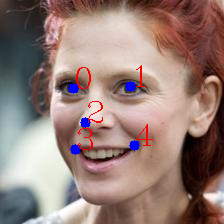

In [7]:
image_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/temp.jpg"
landmark_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/temp.txt"

img_src = cv2.imread(image_path)
# display(Image.fromarray(img_src[..., ::-1]))

landmarks = np.loadtxt(landmark_path)
print(landmarks, landmarks.shape)

landmarks[:, -1] = 224 - 1 - landmarks[:, -1]
draw_points(img_src, landmarks)

display(Image.fromarray(img_src[..., ::-1]))


(5, 2) float64


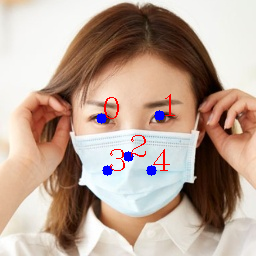

In [16]:
lm_path = "/home/zhanghm/Temp/cv-fighter/face_fighter/data/face_mask.txt"
landmarks = load_landmarks(lm_path)
print(landmarks.shape, landmarks.dtype)

img_src = cv2.imread("/home/zhanghm/Temp/cv-fighter/face_fighter/data/face_mask.jpg")
draw_points(img_src, landmarks)

display(Image.fromarray(img_src[..., ::-1]))

## Draw landmarks in image

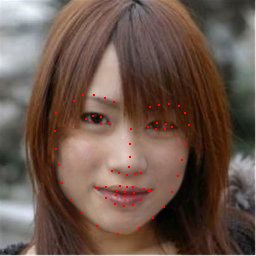

In [5]:
img_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/datasets/HDTF_preprocessed/RD_Radio1_000/face_image/000000.jpg"
lm_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/datasets/HDTF_preprocessed/RD_Radio1_000/face_image/landmarks/000000.txt"

img_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/HDTF_preprocessed/RD_Radio2_000/face_image/000000.jpg"
lm_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/HDTF_preprocessed/RD_Radio2_000/landmarks.npy"


def draw_on_original_image():
    img_src = cv2.imread(img_path)

    landmarks = np.loadtxt(lm_path)
    print(landmarks.shape)

    img = draw_landmarks(img_src, landmarks)

    display(Image.fromarray(img[..., ::-1]))


def draw_on_resized_image():
    img_src = cv2.imread(img_path)
    H, W = img_src.shape[:2]

    img_src = cv2.resize(img_src, (224, 224))

    landmarks = np.loadtxt(lm_path)

    scale = 224 / 512
    print(scale, H)

    landmarks = landmarks * scale

    img = draw_landmarks(img_src, landmarks)

    display(Image.fromarray(img[..., ::-1]))


def draw_on_image(img, landmarks):
    H, W = img.shape[:2]
    # landmarks = landmarks[:, 49:, ] # mouth landmarks
    landmarks[:, -1] = H - 1 - landmarks[:, -1]

    img = draw_landmarks(img, landmarks)

    display(Image.fromarray(img[..., ::-1]))

ldmk = load_landmarks("/home/zhanghm/Research/Face/FaceFusionFormer/temp.txt")
img = cv2.imread("/home/zhanghm/Research/Face/FaceFusionFormer/temp.jpg")

img_path = "/home/zhanghm/Research/Inpainting/face_de_mask/animation/res/1_1.png"
ldmk_path = "/home/zhanghm/Research/Inpainting/face_de_mask/animation/ldmk/1_1.txt"

img = cv2.imread(img_path)
ldmk = load_landmarks(ldmk_path)

draw_on_image(img, ldmk)

## Draw mask region in image

In [2]:
import torch
from einops import rearrange
from icecream import ic


def get_landmark_patch_index(landmarks, patch_size, image_size):
    index_list = []
    for lm in landmarks:
        u, v = lm[:2]
        index = u // patch_size + image_size / patch_size * (v // patch_size)
        index_list.append(int(index))
    return list(set(index_list))


def gen_mouth_mask(landmark_path):
    landmarks = np.load(landmark_path)[0]

    scale = 224 / 512
    landmarks = landmarks * scale

    landmarks = landmarks[49:, ] # mouth landmarks
    index = get_landmark_patch_index(landmarks, patch_size=16, image_size=224)
    ic(len(index), index)
    return index


def gen_mask_pos(mask_type, landmark_path=None):
    if mask_type == "fix_pos":
        mask_per_frame = np.hstack([
            np.zeros(num_patches_per_frame - num_masks_per_frame),
            np.ones(num_masks_per_frame),
        ])
    elif mask_type == "mask_mouth":
        ## 1) Get the landmarks belong to mouth
        mouth_msk_index = gen_mouth_mask(landmark_path)
        
        ## 2) Get the mouth landmarks patch index
        
        pass
    
    return mask_per_frame


img_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/HDTF_preprocessed/WDA_AmyKlobuchar1_003/face_image/000000.jpg"
lm_path = "/home/zhanghm/Research/StyleGAN/Deep3DFaceRecon_pytorch/HDTF_preprocessed/WDA_AmyKlobuchar1_003/landmarks.npy"

mouth_msk_index = gen_mouth_mask(img_path, lm_path)

src_img = cv2.imread(img_path)
src_img = cv2.resize(src_img, (224, 224))

mask_ratio = 0.5
num_patches_per_frame = 14 * 14
patch_size = (16, 16)
num_masks_per_frame = int(mask_ratio * num_patches_per_frame)

# mask_per_frame = np.hstack([
#             np.zeros(num_patches_per_frame - num_masks_per_frame),
#             np.ones(num_masks_per_frame),
#         ])
mask_per_frame = np.zeros(num_patches_per_frame)
mask_per_frame[mouth_msk_index] = 1
ic(mask_per_frame.shape)

bool_masked_pos = torch.from_numpy(mask_per_frame[None, :]).bool()
ic(bool_masked_pos.shape)


src_img_batch = torch.from_numpy(src_img).permute(2, 0, 1).unsqueeze(0) # (B, C, H, W)
img_patch = rearrange(src_img_batch, 'b c (h p1) (w p2) -> b (h w) (p1 p2) c', p1=patch_size[0], p2=patch_size[1])
print(img_patch.shape)

mask = torch.ones_like(img_patch)
mask[bool_masked_pos] = 0
mask = rearrange(mask, 'b (h w) (p1 p2) c -> b c (h p1) (w p2)', p1=patch_size[0], p2=patch_size[1], h=14, w=14)
print(mask.shape)

mask_img = mask[0].permute(1, 2, 0).numpy() * 255

display(Image.fromarray(mask_img[..., ::-1]))

img_mask = src_img_batch * mask
img_mask = img_mask[0].permute(1, 2, 0).numpy()
display(Image.fromarray(img_mask[..., ::-1]))

TypeError: gen_mouth_mask() takes 1 positional argument but 2 were given